# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook

In [2]:
DATA_PATH = Path('../data')

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        filtered_token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(filtered_token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
    
    def _create_sliding_window(self, window_size):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size):
            center_word = islice(self.vectorized_tokens, i, i + 1)
            left_context = islice(self.vectorized_tokens, i + 1, 
                                  min(tokens_size, i + window_size + 1))
            right_context = islice(self.vectorized_tokens, 
                                   max(0, i - window_size), i)
            yield from product(center_word, chain(left_context, right_context))
    
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

In [4]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                      embedding_dim=embedding_size)
        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size,
                             bias=False)
    
    def forward(self, x_in):
        x_embedded = self.embedding(x_in)
        y_out = self.fc1(x_embedded)
        
        return y_out

In [5]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [35]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    
    embedding_size = 50,
    
    seed = 42,
    cutoff = 10,
    window_size = 1,
    batch_size = 128,
    learning_rate = 0.01,
    iterations = 10000,
    early_stopping_criteria = 1e8,
    
    cuda=True
)

In [36]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'batch_idx': 0,
            'loss': []}

def update_train_state(args, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [37]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: True


In [38]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

In [39]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
                          total=args.iterations)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

running_loss = 0.
classifier.train()

for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
    x_batch = x_batch.to(args.device)
    labels_batch = labels_batch.to(args.device)
    
    optimizer.zero_grad()
    
    y_pred = classifier(x_in=x_batch)
    
    loss = loss_func(y_pred, labels_batch)
    loss_value = loss.item()
    running_loss += (loss_value - running_loss) / (batch_idx)
    loss.backward()
    
    optimizer.step()
    
    train_state['batch_idx'] = batch_idx
    train_state['loss'].append(running_loss)
    
    if train_state['stop_early']:
        train_state = update_train_state(args=args,
                                         train_state=train_state)
    
    train_params = dict(loss=running_loss,
                        batch=batch_idx,
                        lr=optimizer.param_groups[0]['lr'])
    train_bar.set_postfix(train_params)
    train_bar.update()
    
    if (batch_idx == args.iterations):
        break

KeyboardInterrupt: 

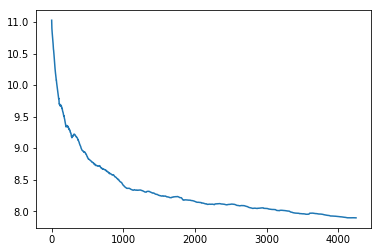

In [40]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

In [173]:
list(classifier.parameters())[0].shape

torch.Size([47134, 50])

In [174]:
list(classifier.parameters())[1].shape

torch.Size([47134, 50])

In [177]:
W = classifier.embedding.weight
W_prime = classifier.fc1.weight

In [178]:
embedding = (W + W_prime) / 2
embedding.shape

torch.Size([47134, 50])

In [58]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=100000)

In [59]:
g = sg_batcher.generate_batches(window_size=5, 
                                batch_size=5)
x_batch, labels_batch = next(g)

x_batch, labels_batch

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 2, 3]))

In [60]:
vocabulary_size = len(sg_batcher.vocab)
embedding_size = 50

vocabulary_size, embedding_size

(22, 50)

In [61]:
clf = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                              embedding_size=embedding_size)

In [102]:
y_pred = clf(x_batch)
# y_pred = F.softmax(y_pred, dim=1)
y_pred

tensor([[ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.078

In [79]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [103]:
y_pred[range(5), labels_batch]

tensor([-0.7678, -0.4254,  0.3084, -0.4254,  0.3084], grad_fn=<IndexBackward>)

In [80]:
-torch.log(y_pred[range(5), labels_batch])

tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NegBackward>)

In [95]:
y_true = torch.zeros((5, vocabulary_size), dtype=torch.long)
y_true[range(5), labels_batch] = 1

In [92]:
y_true.shape, y_pred.shape

(torch.Size([5, 22]), torch.Size([5, 22]))

In [104]:
loss = nn.CrossEntropyLoss(reduce=False)
loss(y_pred, labels_batch)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NllLossBackward>)

In [64]:
arr = torch.zeros((5, vocabulary_size))
arr[range(5), labels_batch] = 1
arr.sum(dim=1)

tensor([1., 1., 1., 1., 1.])

In [65]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [70]:
loss = -np.log()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
